# GFS Wave Global Collection

Reads the Global GFS Wave grib collection from NODD's S3 bucket and creates a single dataset using fsspec's ReferenceFileSystem

This notebook demonstrates how to generate the reference JSON files using Kerchunk. It was adapted from [this notebook](https://nbviewer.org/gist/peterm790/92eb1df3d58ba41d3411f8a840be2452)

In [1]:
import xarray as xr
import datetime as dt
import fsspec
import ujson
from kerchunk.grib2 import scan_grib
from kerchunk.combine import MultiZarrToZarr

Create the virtual filesystem from which to read the NODD s3 bucket. We are going to write the resulting dataset out to our local filesystem, so we leave the write system blank

In [2]:
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

For now, we read all the global data from the given model run 

<i>**TODO**: Read multiple days and model runs to create an FMRC</i>

In [3]:
hourly_files = fs_read.glob('s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.*.grib2')

files = sorted(['s3://'+f for f in hourly_files])
files

['s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f000.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f001.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f002.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f003.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f004.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f005.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f006.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f007.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f008.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f009.grib2',
 's3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f010.grib2',

In [6]:
so = {"anon": True, "use_ssl": False}
json_dir = '../datasets/gfswave_global/'

def make_json_name(file_url, message_number): #create a unique name for each reference file
    date = file_url.split('/')[3].split('.')[1]
    name = file_url.split('/')[7].split('.')[0:5]
    return f'{json_dir}{date}_{name[0]}_{name[1]}_{name[2]}_{name[4]}_message{message_number}.json'

def gen_json(file_url):
    print(f'Processing {file_url}...')
    out = scan_grib(file_url, storage_options=so)   # create the reference using scan_grib
    for i, message in enumerate(out): # scan_grib outputs a list containing one reference per grib message
        out_file_name = make_json_name(file_url, i)  # get name
        with fs_write.open(out_file_name, "w") as f: 
            f.write(ujson.dumps(message)) # write to file

Create all of the zarr reference files for each remote model output file  

In [7]:
%%time
#this step is best run via a cluster
for f in files[0:24]:
    gen_json(f)

Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f000.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f001.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f002.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f003.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f004.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f005.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f006.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f007.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f008.grib2...
Processing s3://noaa-gfs-bdp-pds/gfs.20221028/06/wave/gridded/gfswave.t06z.global.0p25.f009

KeyboardInterrupt: 

Lets list out all the files that we wrote

In [36]:
reference_jsons = fs_write.ls(json_dir) #get list of file names
reference_jsons

['/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f006_message5.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f020_message13.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f020_message0.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f009_message1.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f001_message10.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f014_message10.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f011_message5.json',
 '/Users/matthewiannucci/Developer/zms/examples/../datasets/gfswave_atlantic/20221028_gfswave_t06z_global_f0

Combine the json files to one zarr store and export it to a file

In [40]:
# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(reference_jsons,
                        concat_dims = ['valid_time'],
                        identical_dims=['latitude', 'longitude', 'heightAboveGround', 'step', 'time'])
d = mzz.translate()

with open('../datasets/gfswave_atl_kerchunk.json', 'w') as f:
    f.write(ujson.dumps(d))

Load it back in!

In [9]:
import cf_xarray

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='../datasets/gfswave_global_kerchunk.json', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'valid_time':1}, drop_variables='orderedSequenceData')

ds                      

<xarray.Dataset>
Dimensions:     (valid_time: 24, latitude: 721, longitude: 1440, step: 1,
                 surface: 1, time: 1)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.3 359.5 359.8
  * step        (step) timedelta64[ns] 00:00:00
  * surface     (surface) int64 1
  * time        (time) datetime64[ns] 2022-10-28T06:00:00
  * valid_time  (valid_time) datetime64[ns] 2022-10-28T06:00:00 ... 2022-10-2...
Data variables: (12/13)
    dirpw       (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mpww        (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    perpw       (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    shww        (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    swdir       (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    swell       (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...          ...
    swper       (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u           (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v           (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wdir        (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ws          (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    wvdir       (valid_time, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    centre:             kwbc
    centreDescription:  US National Weather Service - NCEP
    edition:            2
    subCentre:          0

Plot some data

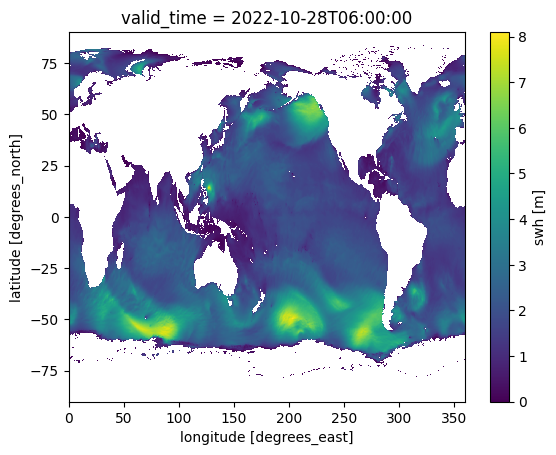

In [10]:
ds.swh[0].plot()

In [17]:
ds.swh

<xarray.DataArray 'swh' (valid_time: 24, latitude: 721, longitude: 1440)>
dask.array<open_dataset-0276be4ffac4806c9d38ac8b6232b9a7swh, shape=(24, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.3 359.5 359.8
  * valid_time  (valid_time) datetime64[ns] 2022-10-28T06:00:00 ... 2022-10-2...
Attributes: (12/18)
    NV:                         0
    cfName:                     unknown
    cfVarName:                  swh
    dataDate:                   20221028
    dataTime:                   600
    dataType:                   fc
    ...                         ...
    paramId:                    140229
    shortName:                  swh
    stepType:                   instant
    stepUnits:                  1
    typeOfLevel:                surface
    units:                      m